In [47]:
# %load /Users/hwayment/ipynb_defaults.py
%load_ext autoreload
%autoreload 2

%pylab inline
import numpy as np
import pandas as pd
import json
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
from RiboGraphViz import RGV
from RiboGraphViz import LoopExtruder, StackExtruder
from ipynb.draw import draw_struct
from nupack import *

from nnn.util import *
from nnn.fileio import *
from nnn.processing import *
from nnn.plotting import *
import nnn.motif_fit as mf

import warnings
warnings.filterwarnings("ignore")

palette = cc.glasbey_dark

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


28424 / 28756, 98.85% varaints passed the chi2 test
86.41% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
28539 / 28756, 99.25% varaints passed the chi2 test
86.08% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
28014 / 28755, 97.42% varaints passed the chi2 test
81.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


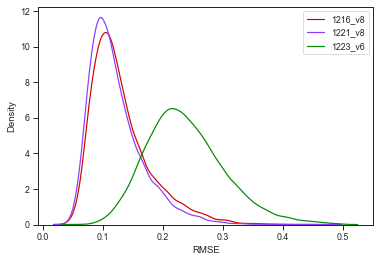

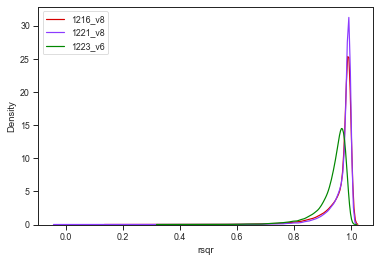

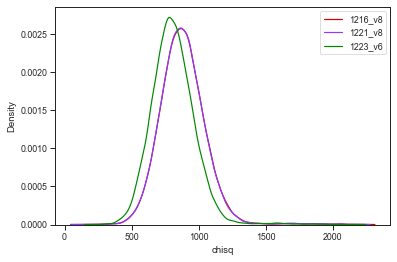

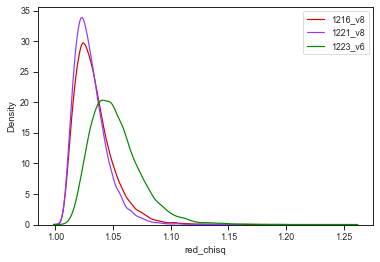

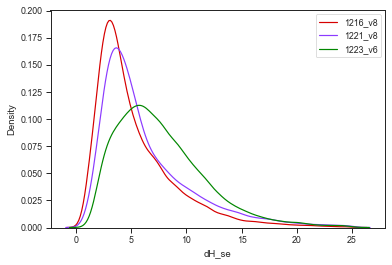

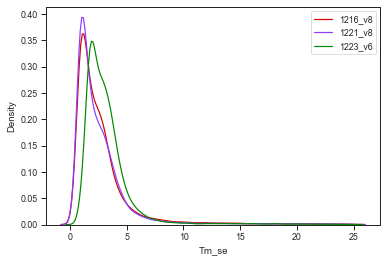

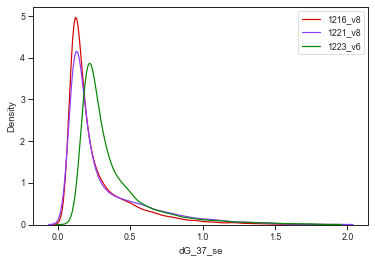

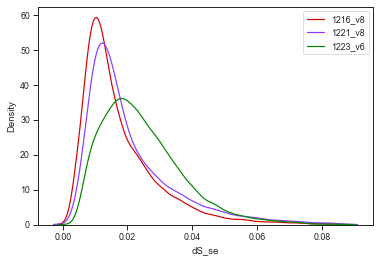

In [51]:
file_list = ['./data/fitted_variant/NNNlib2b_DNA_20211216.CPvariant.gz',
             './data/fitted_variant/NNNlib2b_DNA_20211221_v8.CPvariant.gz',
             './data/fitted_variant/NNNlib2b_DNA_20211223_v6.CPvariant.gz']
dfs = [read_fitted_variant(fn) for fn in file_list]
legend = ['1216_v8', '1221_v8', '1223_v6']

plot_fitting_evaluation(dfs, legend, './fig/fitting_evaluation/v8_Nov11_reps.pdf')

In [60]:
df = pd.read_csv('./data/fitted_single_clusters/NNNlib2b_DNA_20211022.CPfitted.gz', sep='\t')

In [67]:
df.columns

Index(['clusterID', 'fmin', 'fmax', 'dH', 'Tm', 'fmin_stderr', 'fmax_stderr',
       'dH_stderr', 'Tm_stderr', 'RMSE', 'rsqr'],
      dtype='object')

In [86]:
# bad_mask = np.any(np.abs(df[['fmin_stderr', 'fmax_stderr',
#        'dH_stderr', 'Tm_stderr', 'RMSE', 'rsqr']]) > 1e10, axis=1)
bad_mask = df.RMSE > np.percentile(df.RMSE, 99)
np.sum(bad_mask)# / len(df)

31475

In [88]:
np.percentile(df.RMSE, 99.9)

3.1934524083983016

In [2]:
annotation = read_annotation('./data/annotation/NNNlib2b_annotation_nupack.txt',
                             './data/annotation/NNN_mastertable.tsv')
santa_lucia = read_santalucia_df('./data/literature/SantaLucia.tsv')
df = read_fitted_variant('./data/fitted_variant/NNNlib2b_DNA_20211022_v6.CPvariant.gz', annotation=annotation)
df['TargetStruct'] = ['('*int((len(x)-4)/2)+'....'+')'*int((len(x)-4)/2) for x in df['RefSeq']]
df = df.query('ConstructClass == "Watson Crick"')

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


In [176]:
feats = mf.get_feature_count_matrix(df, feature_method='get_stack_feature_list_simple_loop')

y = df['dG_37']
y_err = df['dG_37_se']
A = feats / y_err.values.reshape(-1,1)
b = (y/y_err).values

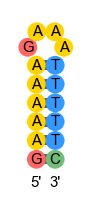

In [178]:
draw_struct(annotation.loc['WC1','RefSeq'], get_target_struct(annotation.loc['WC1']))

In [177]:
feats

,AA_TT,AC_GT,AG_CT,AT_AT,CA_TG,CC_GG,CG_CG,CT_AG,GA_TC,GC_GC,GG_CC,GT_AC,TA_TA,TC_GA,TG_CA,TT_AA,XA_TY,XC_GY,XG_CY,XT_AY
SEQID,,,,,,,,,,,,,,,,,,,,
WC1,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
WC10,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
WC100,1,0,1,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0
WC1000,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0
WC1001,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WC994,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0
WC995,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0,1,0,0,1,0
WC997,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0


In [48]:
np.linalg.matrix_rank(A)

20

In [49]:
u,s,v = np.linalg.svd(A)

plt.plot(s / s[0])
s[-1] / s[0]

In [85]:
s_inv = 1/s
s_inv[s < s[0]*0.0] = 0

In [86]:
nn_se = np.sqrt(np.sum((v * s_inv.reshape(1,-1))**2, axis=1))
nn_se

array([0.01494699, 0.00747069, 0.00763439, 0.00697167, 0.01225667,
       0.00475212, 0.006913  , 0.00959999, 0.00588524, 0.00645596,
       0.00702121, 0.02086175, 0.01321173, 0.0104923 , 0.03051618,
       0.03627451, 0.0198415 , 0.01957365, 0.0113496 , 0.0313225 ])

In [101]:
ubs = (u * b.reshape(-1,1))[:,:M] * s_inv.reshape(1,-1)
# nn = np.sum(u * b.reshape(-1,1) * s_inv.reshape(1,-1) * v, axis=1)

In [95]:
b.shape

(2629,)

In [103]:
ubs.shape

(2629, 20)

In [100]:
M=20

Rank of the design matrix A is 4 / 4
[0.0026652  0.00318212 0.00228587 0.0024782 ]
Rank of the design matrix A is 20 / 20
[0.01494699 0.00747069 0.00763439 0.00697167 0.01225667 0.00475212
 0.006913   0.00959999 0.00588524 0.00645596 0.00702121 0.02086175
 0.01321173 0.0104923  0.03051618 0.03627451 0.0198415  0.01957365
 0.0113496  0.0313225 ]


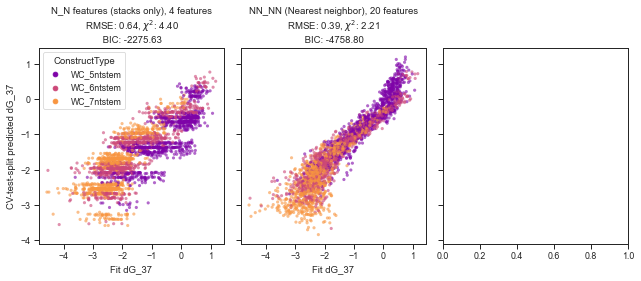

In [15]:
coef_dfs, motif_se, feats, preds, results = mf.fit_linear_motifs(df, feature_method='get_stack_feature_list_simple_loop', err='_se', stack_sizes=[1,2])

Rank of the design matrix A is 20 / 20


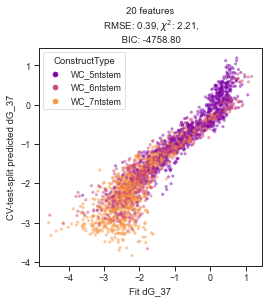

In [16]:
motif_df, feats = mf.fit_NN_cv(df, feature_method='get_stack_feature_list_simple_loop', err='_se')

Rank of the design matrix A is 20 / 20


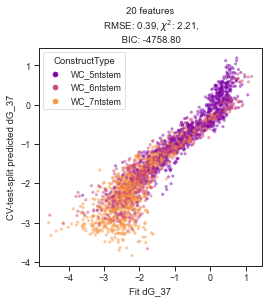

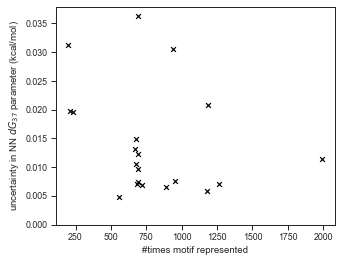

In [163]:
motif_df, feats = mf.fit_NN_cv(df, feature_method='get_stack_feature_list_simple_loop', err='_se')

fig, ax = plt.subplots(figsize=(5,4))
plt.scatter(np.sum(feats, axis=0), motif_df.dG_37_se, color='k', marker='x')
plt.ylim(bottom=0)
plt.xlabel('#times motif represented')
plt.ylabel('uncertainty in NN $dG_{37}$ parameter (kcal/mol)')
save_fig('./fig/motif_fit/WC_uncertainty_dG_37_vs_motif_freq.pdf')

Rank of the design matrix A is 20 / 20


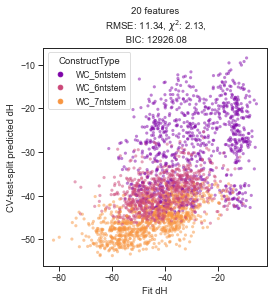

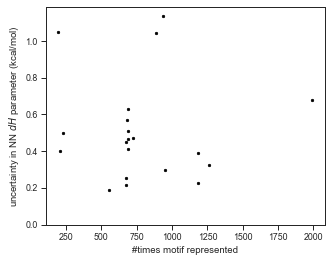

In [17]:
motif_df, feats = mf.fit_NN_cv(df, feature_method='get_stack_feature_list_simple_loop', param='dH', err='_se')

fig, ax = plt.subplots(figsize=(5,4))
plt.scatter(np.sum(feats, axis=0), motif_df.dH_se, color='k', marker='.')
plt.ylim(bottom=0)
plt.xlabel('#times motif represented')
plt.ylabel('uncertainty in NN $dH$ parameter (kcal/mol)')
save_fig('./fig/motif_fit/WC_uncertainty_dH_vs_motif_freq.pdf')

Rank of the design matrix A is 20 / 20


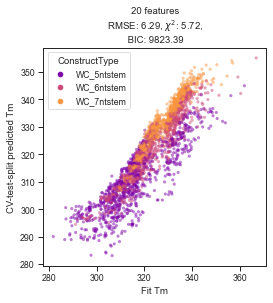

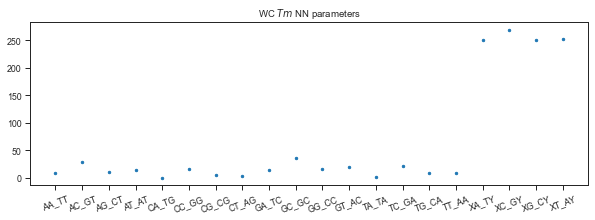

In [41]:
param = 'Tm'

motif_df, _ = mf.fit_NN_cv(df, feature_method='get_stack_feature_list_simple_loop', param=param, err='_se')

plot_motif_param_errorbar(motif_df, param)
save_fig('./fig/motif_fit/WC_NN_param_%s.pdf'%param)
plt.show()

Rank of the design matrix A is 20 / 20


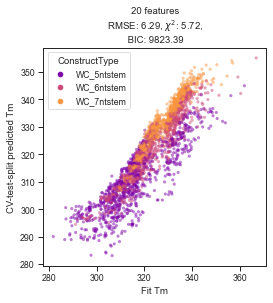

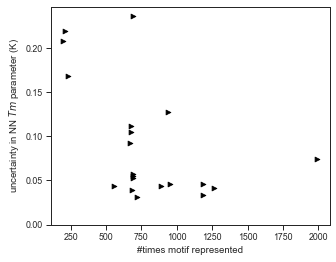

In [161]:
motif_df, feats = mf.fit_NN_cv(df, feature_method='get_stack_feature_list_simple_loop', param='Tm', err='_se')

fig, ax = plt.subplots(figsize=(5,4))
plt.scatter(np.sum(feats, axis=0), motif_df.Tm_se, color='k', marker='>')
plt.ylim(bottom=0)
plt.xlabel('#times motif represented')
plt.ylabel('uncertainty in NN $Tm$ parameter (K)')

save_fig('./fig/motif_fit/WC_uncertainty_Tm_vs_motif_freq.pdf')

In [ ]:
compare_fit_with_santalucia(df, santa_lucia, params=['dH', 'dS', 'dG_37'])

## MFE structures

In [115]:
df.columns

Index(['Green14_20_norm', 'Green14_20_norm_std', 'Green15_22.5_norm',
       'Green15_22.5_norm_std', 'Green16_25_norm', 'Green16_25_norm_std',
       'Green17_27.5_norm', 'Green17_27.5_norm_std', 'Green18_30_norm',
       'Green18_30_norm_std', 'Green19_32.5_norm', 'Green19_32.5_norm_std',
       'Green20_35_norm', 'Green20_35_norm_std', 'Green21_37.5_norm',
       'Green21_37.5_norm_std', 'Green22_40_norm', 'Green22_40_norm_std',
       'Green23_42.5_norm', 'Green23_42.5_norm_std', 'Green24_45_norm',
       'Green24_45_norm_std', 'Green25_47.5_norm', 'Green25_47.5_norm_std',
       'Green26_50_norm', 'Green26_50_norm_std', 'Green27_52.5_norm',
       'Green27_52.5_norm_std', 'Green28_55_norm', 'Green28_55_norm_std',
       'Green29_57.5_norm', 'Green29_57.5_norm_std', 'Green30_60_norm',
       'Green30_60_norm_std', 'RMSE', 'Tm', 'Tm_lb', 'Tm_se', 'Tm_ub', 'chisq',
       'dG_37', 'dG_37_lb', 'dG_37_se', 'dG_37_ub', 'dH', 'dH_lb', 'dH_se',
       'dH_ub', 'dS', 'dS_lb', 'dS_se', 'dS_

In [108]:
my_model = Model(material='DNA', celsius=76, sodium=1, magnesium=0.0)
mfe_structures = mfe(strands=['CCATGGAAACATGG'], model=my_model)
print('Number of mfe structures:', len(mfe_structures))
print('Free energy of MFE proxy structure: %.2f kcal/mol' % mfe_structures[0].energy)
print('MFE proxy structure in dot-parens-plus notation: %s' % mfe_structures[0].structure)

Number of mfe structures: 1
Free energy of MFE proxy structure: -0.06 kcal/mol
MFE proxy structure in dot-parens-plus notation: (((((....)))))


In [73]:
from nnn.util import *
get_mfe_struct('AACCATGGAAACATGGAA', celsius=0)

'..(((((....)))))..'

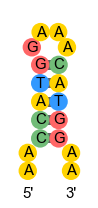

In [107]:
draw_struct('AACCATGGAAACATGGAA', '..(((((....)))))..')

In [85]:
mfe_struct = annotation.query('Series == "Bulges"').RefSeq[:10].apply(get_mfe_struct)

In [97]:
np.unique(annotation.Series)

array(['BaeControls', 'Bulges', 'MisMatchesACanyPos',
       'MisMatchesCentered', 'MisMatchesGTanyPos', 'PUMcontrols',
       'PolyNTControls', 'PseudoKnots', 'REPeatControls', 'StemDangle',
       'SuperStem', 'TETRAloop', 'TRIloop', 'VariableLoops', 'WBcontrols',
       'WatsonCrick'], dtype=object)

In [165]:
get_target_struct(annotation.loc['MMACP1'])

'(((((.(....).)))))'

                   RefSeq          mfe_struct
SEQID                                        
BNN0    CGAAACGGAAACGTTCG   ...((((....))))..
BNN1    CGAACGGAAACGTATCG   ((((((....))).)))
BNN2   CGAAAACGGAAACGTTCG  ....((((....))))..
BNN3   CGAACGGAAACGTAATCG  ((((((....)))..)))
BNN4   CGAACACGGAAACGTTCG  (((..(((....))))))
BNN5   CGAACGGAAACGTACTCG  ((((((....)))..)))
BNN6   CGAATACGGAAACGTTCG  (((..(((....))))))
BNN7   CGAACGGAAACGTATTCG  ((((((....)))..)))
BNN8   CGAAGACGGAAACGTTCG  (...)(((....)))...
BNN9   CGAACGGAAACGTAGTCG  ((((((....)))..)))
BNN10   CGACACGGAAACGTTCG   (((.(((....))))))
BNN11   CGAACGGAAACGTCTCG   ((((((....))).)))
BNN12  CGACAACGGAAACGTTCG  ....((((....))))..
BNN13  CGAACGGAAACGTCATCG  ((((((....)))..)))
BNN14  CGACCACGGAAACGTTCG  (((..(((....))))))
BNN15  CGAACGGAAACGTCCTCG  ((((((....)))..)))
BNN16  CGACTACGGAAACGTTCG  (((..(((....))))))
BNN17  CGAACGGAAACGTCTTCG  ((((((....)))..)))
BNN18  CGACGACGGAAACGTTCG  ...(((((....))).))
BNN19  CGAACGGAAACGTCGTCG  ((((((.

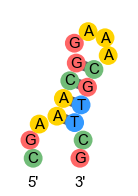

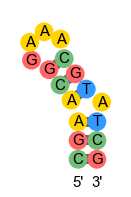

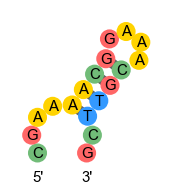

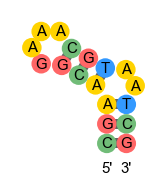

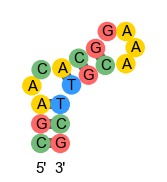

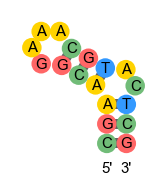

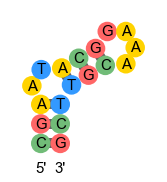

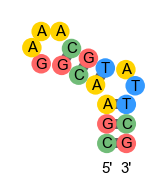

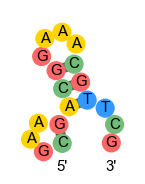

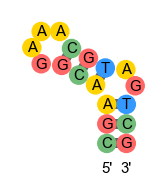

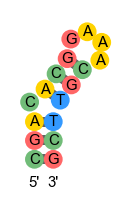

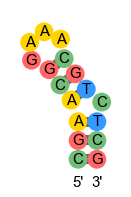

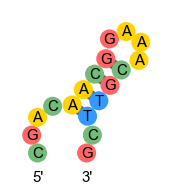

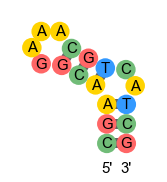

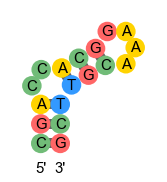

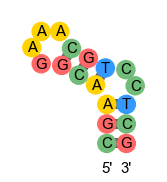

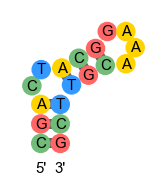

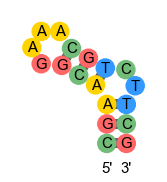

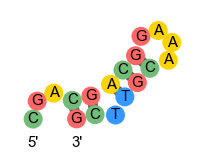

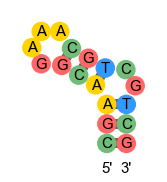

In [175]:
from nnn.util import *
test_df = annotation.query('Series == "Bulges"').iloc[:20,:]
test_df['mfe_struct'] = test_df.RefSeq.apply(lambda x: get_mfe_struct(x, celsius=25))
# test_df['target_struct'] = test_df.apply(get_target_struct, axis=1)
print(test_df[['RefSeq','mfe_struct']])
for i in range(20):
    draw_struct(test_df.iloc[i,:].RefSeq, test_df.iloc[i,:].mfe_struct)
    # draw_struct(test_df.iloc[i,:].RefSeq, test_df.iloc[i,:].target_struct)